# Predicting 2024 US Corn Yield

## Download data

In [ ]:
# Importing necessary libraries
import requests
import time
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd

In [ ]:
# Reading the API key from a file
with open('API_key.txt') as f:
    api_key = f.read()

In [ ]:
# Setting up API parameters
API_KEY = api_key
BASE_URL = 'http://quickstats.nass.usda.gov/api/api_GET/'
OUTPUT_DIR = 'corn_yield_csv'
os.makedirs(OUTPUT_DIR, exist_ok=True)

# Select years for collection
START_YEAR = 1910
END_YEAR = 2024

for year in range(START_YEAR, END_YEAR + 1):
    params = {
        'key': API_KEY,
        'commodity_desc': 'CORN',
        'statisticcat_desc': 'YIELD',
        'unit_desc': 'BU / ACRE',
        'agg_level_desc': 'COUNTY',
        'year': year,
        'format': 'JSON'
    }

    try:
        print(f"Downloading data for year {year}...")
        response = requests.get(BASE_URL, params=params)
        response.raise_for_status()
        data = response.json()

        records = data.get('data', [])
        if not records:
            print(f"No data for {year}, next.")
            continue

        df = pd.DataFrame(records)

        # Saving the DataFrame to a CSV file
        csv_path = os.path.join(OUTPUT_DIR, f"corn_yield_{year}_county.csv")
        df.to_csv(csv_path, index=False)
        print(f"Saved {csv_path} with {len(df)} record.")
        time.sleep(3)  

    except requests.exceptions.RequestException as e:
        print(f"Error for year {year}: {e}")
        time.sleep(5)

In [ ]:
# Assembling all CSV files into a single dataset
INPUT_DIR = 'corn_yield_csv'
OUTPUT_FILE = 'corn_yield_all_years_county.csv'

files = [os.path.join(INPUT_DIR, f) for f in os.listdir(INPUT_DIR) if f.endswith('.csv')]
dfs = []

for file in sorted(files):
    print(f"Loading {file}...")
    df = pd.read_csv(file)

    # clean the 'Value' column for consistency
    def clean_value(val):
        try:
            return float(str(val).replace(",", ""))
        except:
            return None
    df['Value'] = df['Value'].apply(clean_value)

    dfs.append(df)

if dfs:
    full_df = pd.concat(dfs, ignore_index=True)
    full_df.to_csv(OUTPUT_FILE, index=False)
    print(f"Dataset complete saved in '{OUTPUT_FILE}'.")
else:
    print("There are no files to assemble")

Loading corn_yield_csv\corn_yield_1910_county.csv...
Loading corn_yield_csv\corn_yield_1911_county.csv...
Loading corn_yield_csv\corn_yield_1912_county.csv...
Loading corn_yield_csv\corn_yield_1913_county.csv...
Loading corn_yield_csv\corn_yield_1914_county.csv...
Loading corn_yield_csv\corn_yield_1915_county.csv...
Loading corn_yield_csv\corn_yield_1916_county.csv...
Loading corn_yield_csv\corn_yield_1917_county.csv...
Loading corn_yield_csv\corn_yield_1918_county.csv...
Loading corn_yield_csv\corn_yield_1919_county.csv...
Loading corn_yield_csv\corn_yield_1920_county.csv...
Loading corn_yield_csv\corn_yield_1921_county.csv...
Loading corn_yield_csv\corn_yield_1922_county.csv...
Loading corn_yield_csv\corn_yield_1923_county.csv...
Loading corn_yield_csv\corn_yield_1924_county.csv...
Loading corn_yield_csv\corn_yield_1925_county.csv...
Loading corn_yield_csv\corn_yield_1926_county.csv...
Loading corn_yield_csv\corn_yield_1927_county.csv...
Loading corn_yield_csv\corn_yield_1928_county.

## Explorative analysis

### Yield Data

In [ ]:
# Reading the assembled dataset
df = pd.read_csv('corn_yield_all_years_county.csv')

In [ ]:
# Displaying basic statistics of the dataset
df.describe()

,region_desc,state_fips_code,country_code,state_ansi,week_ending,county_code,county_ansi,congr_district_code,end_code,begin_code,Value,watershed_desc,watershed_code,CV (%),year,zip_5,asd_code
count,0.0,221557.000000,221557.0,221557.000000,0.0,221557.000000,213879.000000,0.0,221557.0,221557.0,221557.000000,0.0,221557.0,7506.000000,221557.000000,0.0,221557.000000
mean,NaN,30.088032,9000.0,30.088032,NaN,124.446865,93.087353,NaN,0.0,0.0,81.044844,NaN,0.0,5.555622,1978.090415,NaN,49.885844
std,NaN,13.262452,0.0,13.262452,NaN,179.477601,70.645899,NaN,0.0,0.0,48.957053,NaN,0.0,4.511936,25.600817,NaN,25.498104
min,NaN,1.000000,9000.0,1.000000,NaN,1.000000,1.000000,NaN,0.0,0.0,0.000000,NaN,0.0,0.500000,1910.000000,NaN,10.000000
25%,NaN,20.000000,9000.0,20.000000,NaN,41.000000,39.000000,NaN,0.0,0.0,40.000000,NaN,0.0,2.700000,1960.000000,NaN,30.000000
50%,NaN,29.000000,9000.0,29.000000,NaN,87.000000,83.000000,NaN,0.0,0.0,73.600000,NaN,0.0,4.100000,1980.000000,NaN,50.000000
75%,NaN,39.000000,9000.0,39.000000,NaN,139.000000,133.000000,NaN,0.0,0.0,114.600000,NaN,0.0,6.900000,1998.000000,NaN,70.000000
max,NaN,56.000000,9000.0,56.000000,NaN,998.000000,810.000000,NaN,0.0,0.0,296.300000,NaN,0.0,63.400000,2024.000000,NaN,99.000000


Many columns are redundant or not relevant to the task, so I decided to select a subset of columns for further analysis.

In [4]:
df.columns

Index(['source_desc', 'region_desc', 'group_desc', 'agg_level_desc',
       'state_name', 'country_name', 'statisticcat_desc', 'domaincat_desc',
       'state_fips_code', 'country_code', 'sector_desc', 'state_ansi',
       'week_ending', 'county_code', 'prodn_practice_desc', 'county_ansi',
       'reference_period_desc', 'congr_district_code', 'unit_desc', 'end_code',
       'asd_desc', 'load_time', 'begin_code', 'Value', 'domain_desc',
       'util_practice_desc', 'watershed_desc', 'short_desc', 'watershed_code',
       'class_desc', 'commodity_desc', 'freq_desc', 'county_name', 'CV (%)',
       'state_alpha', 'location_desc', 'year', 'zip_5', 'asd_code'],
      dtype='object')

In [ ]:
# Defining interest columns 
interest_columns = ['year','country_name','state_name','county_name','Value']

In [ ]:
# Selecting only the interest columns
df = df.loc[:, interest_columns]

In [ ]:
# Looking for missing values. The data seems to be clean, but let's check.
df.isna().sum()

year            0
country_name    0
state_name      0
county_name     0
Value           0
dtype: int64

In [8]:
# Aggregation for state and year
year_state_mean = df.groupby(['year', 'state_name'])['Value'].mean().reset_index()

In [ ]:
# Aggregation for national average
year_mean = df.groupby(['year'])['Value'].mean().reset_index()

In [ ]:
# Plotting the start and end year for each state. Some states do not have data for all years.
state_year_range = year_state_mean.groupby('state_name')['year'].agg(['min', 'max'])
print(state_year_range)


                 min   max
state_name                
ALABAMA         1939  2024
ARIZONA         1965  2008
ARKANSAS        1961  2024
CALIFORNIA      1959  2023
COLORADO        1963  2024
DELAWARE        1928  2024
FLORIDA         1961  2009
GEORGIA         1954  2024
IDAHO           1972  2024
ILLINOIS        1925  2024
INDIANA         1929  2024
IOWA            1926  2024
KANSAS          1958  2024
KENTUCKY        1929  2024
LOUISIANA       1959  2024
MARYLAND        1928  2024
MICHIGAN        1942  2024
MINNESOTA       1921  2024
MISSISSIPPI     1953  2024
MISSOURI        1919  2024
MONTANA         1944  2016
NEBRASKA        1910  2024
NEW JERSEY      1953  2016
NEW MEXICO      1956  2016
NEW YORK        1972  2024
NORTH CAROLINA  1925  2024
NORTH DAKOTA    1919  2024
OHIO            1918  2024
OKLAHOMA        1933  2024
OREGON          1956  2009
PENNSYLVANIA    1960  2024
SOUTH CAROLINA  1944  2024
SOUTH DAKOTA    1924  2024
TENNESSEE       1955  2024
TEXAS           1968  2024
U

In [ ]:
# Displaying the first few rows of the full dataset
df.head()

,year,country_name,state_name,county_name,Value
0,1910,UNITED STATES,NEBRASKA,BANNER,14.4
1,1910,UNITED STATES,NEBRASKA,BOX BUTTE,16.0
2,1910,UNITED STATES,NEBRASKA,CHEYENNE,9.6
3,1910,UNITED STATES,NEBRASKA,DAWES,16.4
4,1910,UNITED STATES,NEBRASKA,DEUEL,17.5


In [ ]:
# Group by state to get average yield across all years
state_avg_yield = df.groupby('state_name')['Value'].mean().reset_index()

In [ ]:
# First 5 states with the highest average yield
state_avg_yield.sort_values(by='Value', ascending=False).head(5)

,state_name,Value
8,IDAHO,129.907670
3,CALIFORNIA,119.936595
35,UTAH,111.171765
24,NEW YORK,109.179003
1,ARIZONA,107.542978


### Visualization of the Yield data

Using the Shapefile of state boundaries: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html

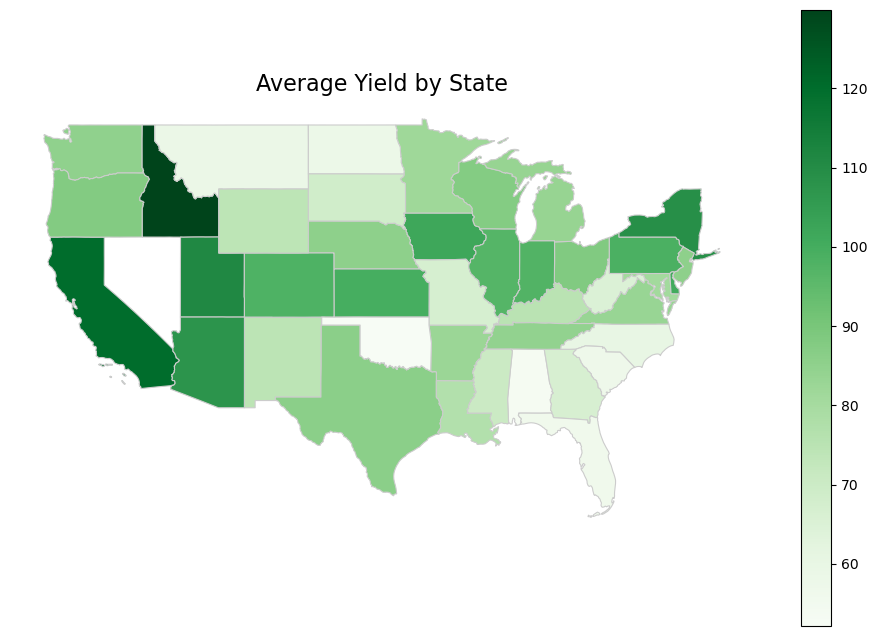

In [ ]:
# Load US state shapefile
states = gpd.read_file("cb_2018_us_state_20m.zip")

# Ensure consistent casing for merge
states['NAME'] = states['NAME'].str.upper()
state_avg_yield['state_name'] = state_avg_yield['state_name'].str.upper()

# Merging data
merged = states.merge(state_avg_yield, left_on='NAME', right_on='state_name')

# Plotting the average yield by state
fig, ax = plt.subplots(1, 1, figsize=(12, 8))
merged.plot(column='Value', cmap='Greens', linewidth=0.8, edgecolor='0.8', legend=True, ax=ax)
ax.set_title('Average Yield by State', fontsize=16)
ax.axis('off')
plt.show()

In [ ]:
# Looking at the stats of the yield values
df['Value'].describe()

count    221557.000000
mean         81.044844
std          48.957053
min           0.000000
25%          40.000000
50%          73.600000
75%         114.600000
max         296.300000
Name: Value, dtype: float64

Quite large std, indicating high variability of yield and a quarter of the data is below this value

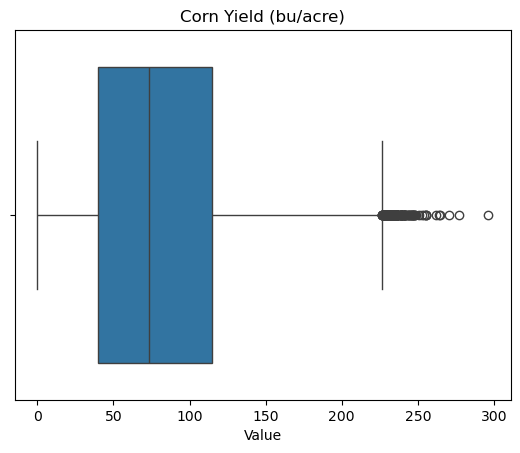

In [ ]:
# Visualizing the distribution of corn yield values
sns.boxplot(df['Value'], orient='h')
plt.title('Corn Yield (bu/acre)')
plt.show()

The majority of yields are clustered below 150 bu/acre, with a concentration in the 50–100 range <br>
There’s a long tail of exceptional yields, likely from regions or years with optimal conditions

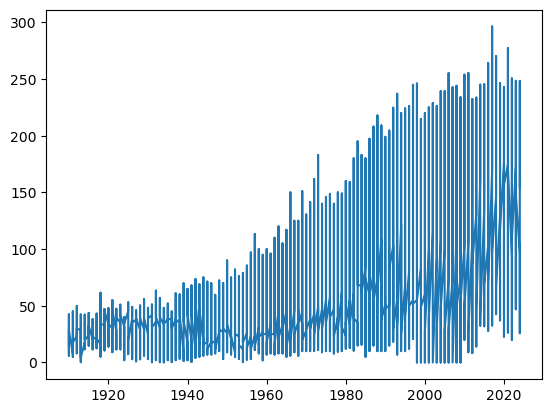

In [18]:
plt.plot(df['year'], df['Value'])
plt.show()

From 1920 to 2020 there has been a sharp increase in yield values, suggesting steady growth. Probably a sign of improved productivity due to technology. <br>
It is interesting to note that since 1960 the values have begun to rise more rapidly, most likely due to significant advances in hybrid crops. <br>
It is also possible to see that there are significant declines and peaks, most likely related to weather conditions or other global events.

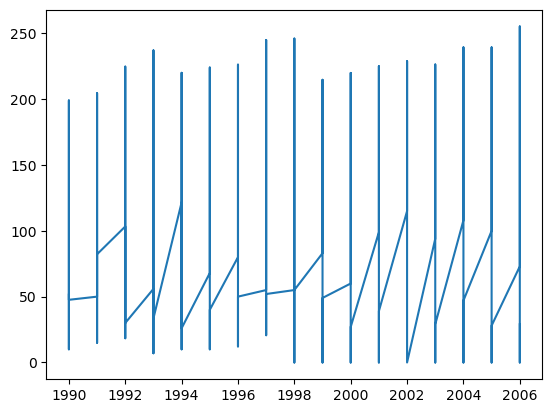

In [19]:
df_filtered = df[(df['year'] >= 1990) & (df['year'] <= 2006)]
plt.plot(df_filtered['year'], df_filtered['Value'])
plt.show()


In particular, between approximately 1990 and 2006, there were several locations with very low yields.

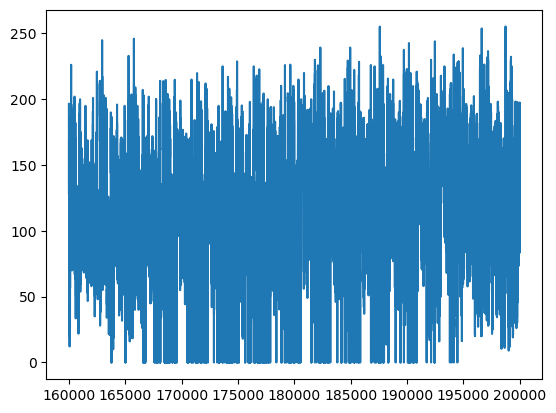

In [20]:
plt.plot(df['Value'].loc[160000:200000])
plt.show()

In [155]:
# Setting the index to 'year' for time series analysis for average yield
ts = year_mean.set_index('year')
ts_yield = pd.Series(ts['Value'])

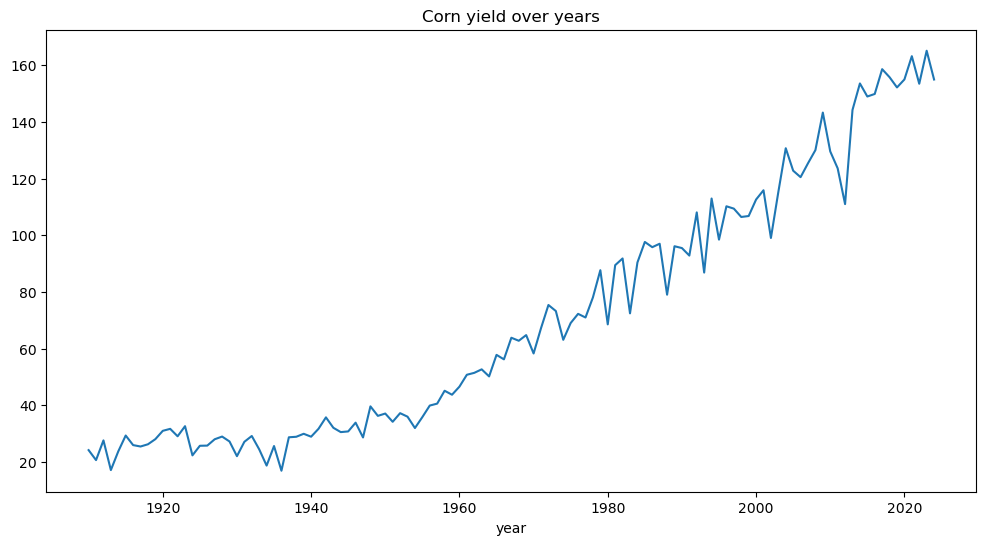

In [156]:
ts_yield.plot(legend=False, title='Corn yield over years', figsize=(12, 6))
plt.show()

In [157]:
# Calculating the average yield for each state
state_means = year_state_mean.groupby('state_name')['Value'].mean()
# Finding the states with the highest and lowest average yield
top_state = state_means.idxmax()
bottom_state = state_means.idxmin()

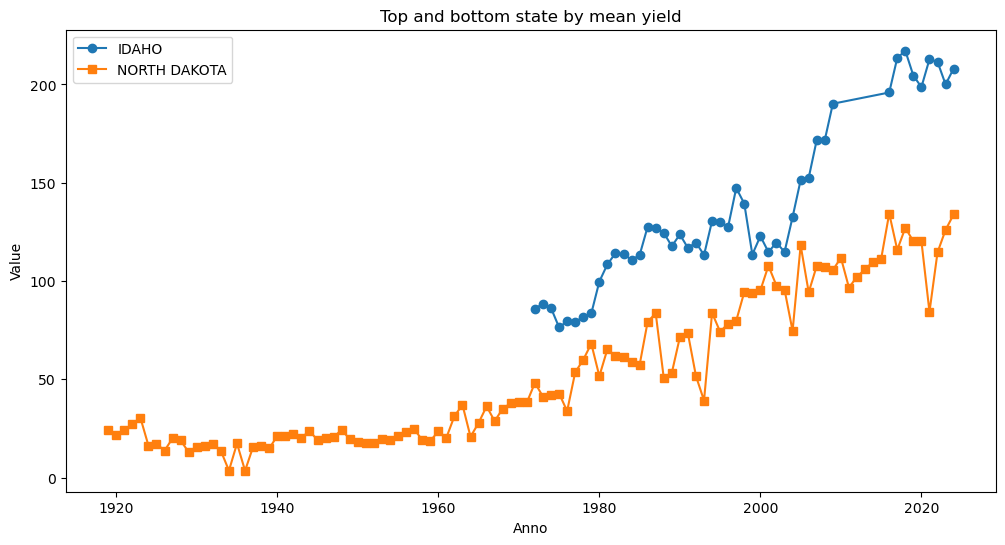

In [158]:
# Plotting the top and bottom states by mean yield
top_data = year_state_mean[year_state_mean['state_name'] == top_state]
bottom_data = year_state_mean[year_state_mean['state_name'] == bottom_state]

plt.figure(figsize=(12, 6))
plt.plot(top_data['year'], top_data['Value'], marker='o', label=top_state)
plt.plot(bottom_data['year'], bottom_data['Value'], marker='s', label=bottom_state)

plt.title("Top and bottom state by mean yield")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()


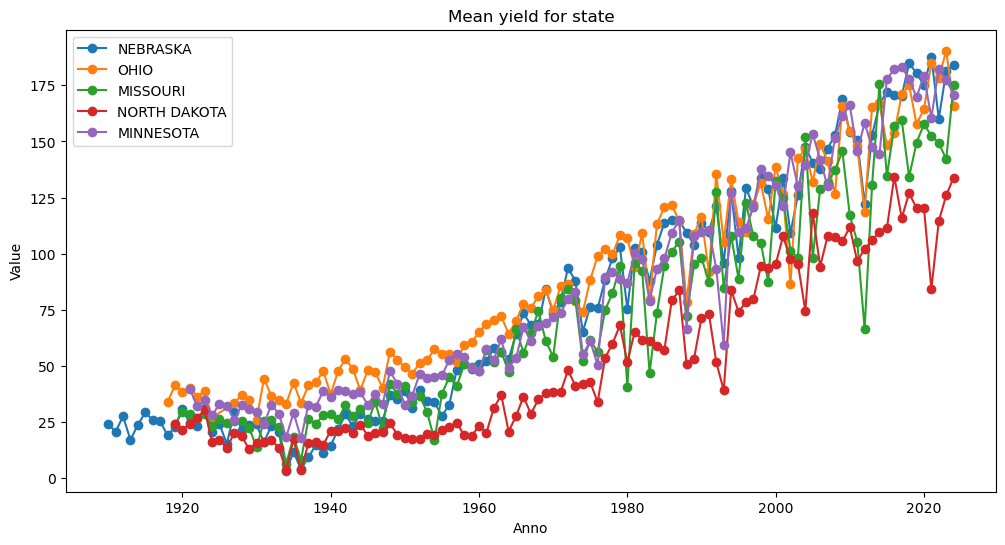

In [159]:
# Graph for the firts 10 states
states_to_plot = year_state_mean['state_name'].unique()[:5]  

plt.figure(figsize=(12, 6))
for state in states_to_plot:
    data = year_state_mean[year_state_mean['state_name'] == state]
    plt.plot(data['year'], data['Value'], marker='o', label=state)

plt.title("Mean yield for state")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()

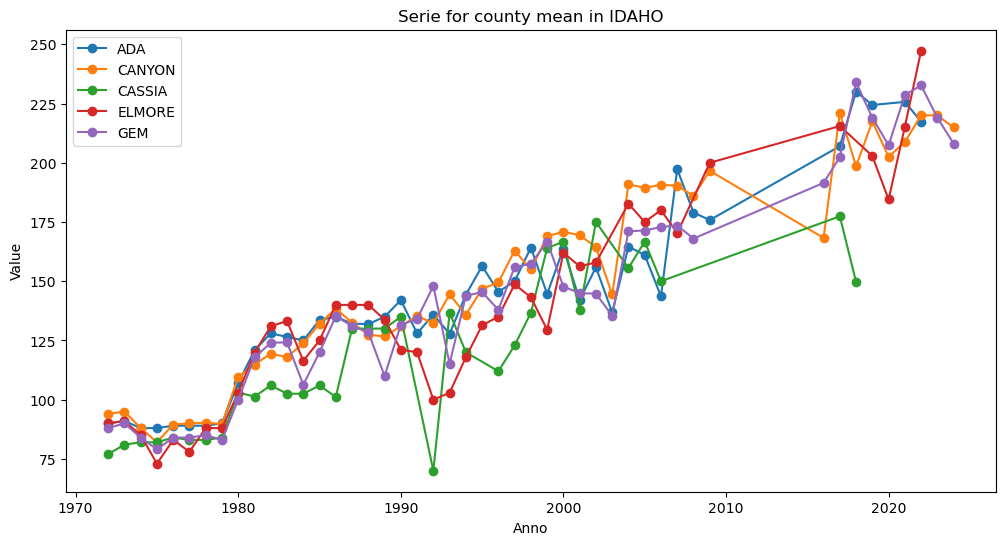

In [160]:
# Serie for county in a specific state
state_example = 'IDAHO'
county_time_series = df[df['state_name'] == state_example].groupby(['year', 'county_name'])['Value'].mean().reset_index()

# Selezioniamo alcuni county per il grafico (massimo 5)
counties_to_plot = county_time_series['county_name'].unique()[:5]

plt.figure(figsize=(12, 6))
for county in counties_to_plot:
    data = county_time_series[county_time_series['county_name'] == county]
    plt.plot(data['year'], data['Value'], marker='o', label=county)

plt.title(f"Serie for county mean in {state_example}")
plt.xlabel("Anno")
plt.ylabel("Value")
plt.legend()
plt.show()

In earlier years (1970-80), the counties' values are close together, but all counties show a clear increasing trend in the variable over the decades. <br>
Around 1991, CASSIA shows a sharp drop and around 2022, ELMORE spikes to nearly 250, higher than others. There seems to be also a gap between 2010 and 2016.

In [ ]:
# checking for the gap
df[df['state_name']== 'IDAHO'].groupby(['year', 'county_name'])['Value'].mean().reset_index()['year'].unique()

array([1972, 1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982,
       1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993,
       1994, 1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004,
       2005, 2006, 2007, 2008, 2009, 2016, 2017, 2018, 2019, 2020, 2021,
       2022, 2023, 2024], dtype=int64)

### Weather Data

In [ ]:
# Reading the weather data
hist_wx_df = pd.read_parquet('hist_wx_df.parquet')

In [ ]:
# Displaying the first few rows of the weather data
hist_wx_df.head()

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name
0,USA.14.100_1,2000-01-01,9.146448,-0.300685,0.000000,0.333584,0.316295,Will,Illinois
1,USA.14.100_1,2000-01-02,16.077440,4.774050,0.000000,0.343324,0.317686,Will,Illinois
2,USA.14.100_1,2000-01-03,9.560367,1.645247,0.466668,0.342535,0.320476,Will,Illinois
3,USA.14.100_1,2000-01-04,3.089767,-3.193717,1.183839,0.379731,0.338481,Will,Illinois
4,USA.14.100_1,2000-01-05,-1.597997,-8.902274,0.000000,0.353221,0.343165,Will,Illinois


In [ ]:
# Displaying basic statistics of the weather data
hist_wx_df.describe().round(2)

,date,tmax,tmin,precip,swvl1,swvl2
count,8527402,8527402.00,8527402.00,8527402.00,8527402.00,8527402.00
mean,2012-03-02 03:27:13.931177984,16.46,6.88,2.36,0.32,0.32
min,2000-01-01 00:00:00,-32.29,-41.80,0.00,0.05,0.06
25%,2006-02-01 00:00:00,7.55,-1.34,0.00,0.27,0.26
50%,2012-03-03 00:00:00,17.97,7.70,0.00,0.34,0.33
75%,2018-04-02 00:00:00,26.25,16.38,1.50,0.38,0.38
max,2024-04-30 00:00:00,44.19,31.56,224.63,0.63,0.63
std,NaN,11.63,11.14,6.34,0.08,0.08


A solid standard deviation for temperature indicate noticeable variation across regions or seasons, extreme rainfall events do exist (max of 224.63)

In [ ]:
# Checking for missing values in the weather data
hist_wx_df.isnull().sum()

aoi_id       0
date         0
tmax         0
tmin         0
precip       0
swvl1        0
swvl2        0
adm2_name    0
adm1_name    0
dtype: int64

<Axes: xlabel='tmax'>

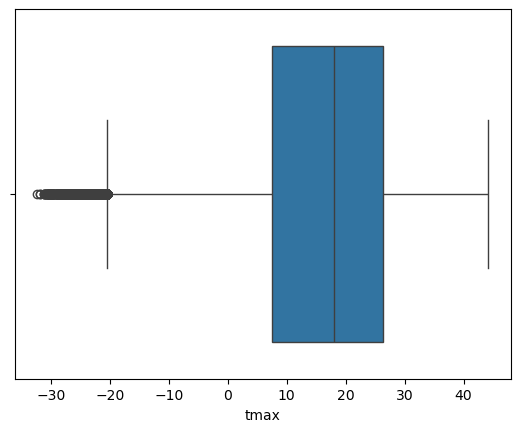

In [ ]:
# Boxplot for temperature max
sns.boxplot(hist_wx_df['tmax'], orient='h')

A long tail towards very low values (outliers), which could represent measurement errors, <br>
anomalous data, or possibly extreme weather conditions. <br>
I would expect these values in winter, I checked: 

In [ ]:
extr_temp = hist_wx_df[hist_wx_df['tmax'] < -20]
extr_temp = extr_temp.copy()

In [ ]:
# adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())


month
1.0     3436
2.0      882
3.0       21
12.0    1610
Name: count, dtype: int64


All the extreme events are in winter

<Axes: xlabel='tmin'>

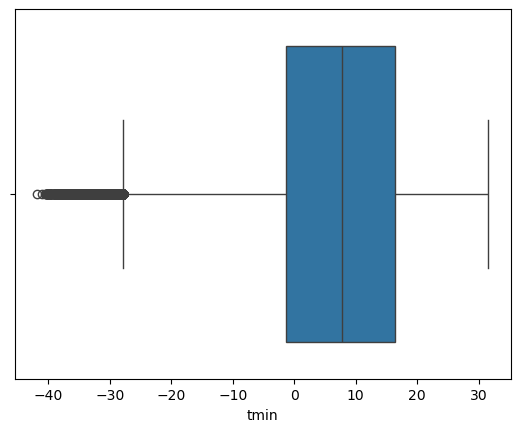

In [ ]:
# Checking also for temperature min
sns.boxplot(hist_wx_df['tmin'], orient='h')
plt.plot()

In [154]:
extr_temp = hist_wx_df[hist_wx_df['tmin'] < -20]
extr_temp = extr_temp.copy()

# adding month and year columns for extreme temperature events
extr_temp['month'] = extr_temp['date'].dt.month
extr_temp['year'] = extr_temp['date'].dt.year

# Count how many extreme events per month
print(extr_temp['month'].value_counts().sort_index())

month
1     52983
2     39579
3      5269
4         4
10        8
11      242
12    23178
Name: count, dtype: int64


In this case too, low temperatures were recorded in winter, apart from four in April, which is plausible given the spring frosts.

<Axes: xlabel='precip'>

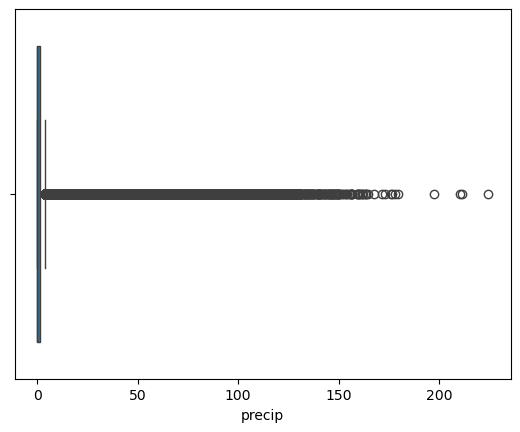

In [ ]:
# Boxplot for precipitation
sns.boxplot(hist_wx_df['precip'], orient='h')
plt.show()

The box plot show clearly highlights a common problem in precipitation data, <br>
the presence of very high outliers and a strongly asymmetrical (skewed) distribution because there a lot of days without rain. <br>
There are several values at the limit, but it is probably an example of extreme weather behaviour, which could be useful for climate modelling or trend analysis.

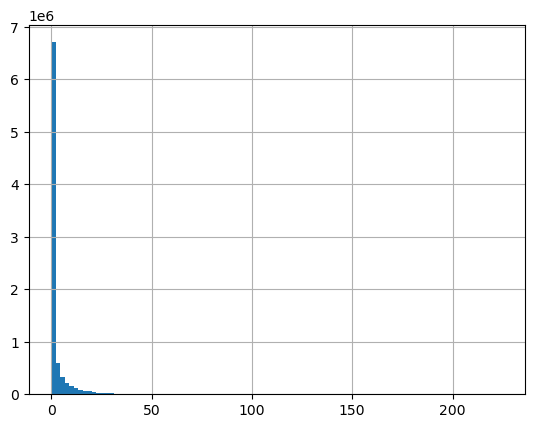

In [146]:
hist_wx_df['precip'].hist(bins=100)
plt.show()

In [29]:
hist_wx_df['rain_flag'] = pd.cut(
    hist_wx_df['precip'],
    bins=[-0.1, 0, 50, float('inf')],
    labels=[0, 1, 2],
    right=True
).astype(int)

In [30]:
#hist_wx_df['rain_flag'].hist()
#plt.show()

## Timeseries

In [38]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [39]:
ts = year_mean.set_index('year')
ts_yield = pd.Series(ts['Value'])

In [40]:
ts_yield.isna().sum()

np.int64(0)

In [41]:
ts_yield

year
1910     24.149462
1911     20.627957
1912     27.587097
1913     17.106452
1914     23.718280
           ...    
2020    155.028303
2021    163.246946
2022    153.514138
2023    165.174915
2024    155.005130
Name: Value, Length: 115, dtype: float64

In [42]:
type(ts_yield)

pandas.core.series.Series

In [43]:
ts_yield.index

Index([1910, 1911, 1912, 1913, 1914, 1915, 1916, 1917, 1918, 1919,
       ...
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023, 2024],
      dtype='int64', name='year', length=115)

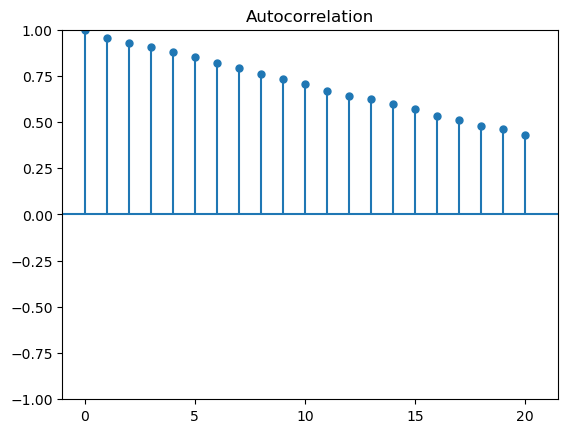

In [44]:
plot_acf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

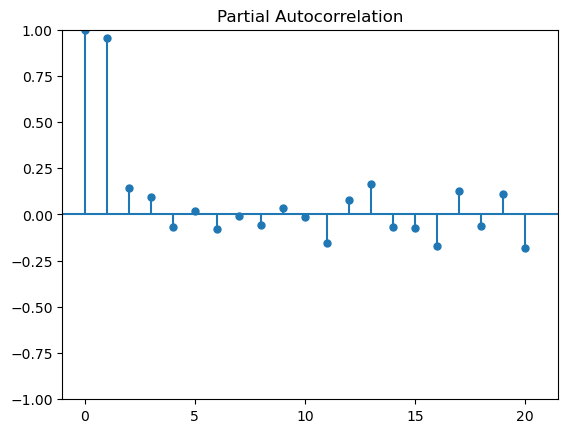

In [45]:
plot_pacf(ts_yield.values[11:], lags=20, alpha=1)
plt.show()

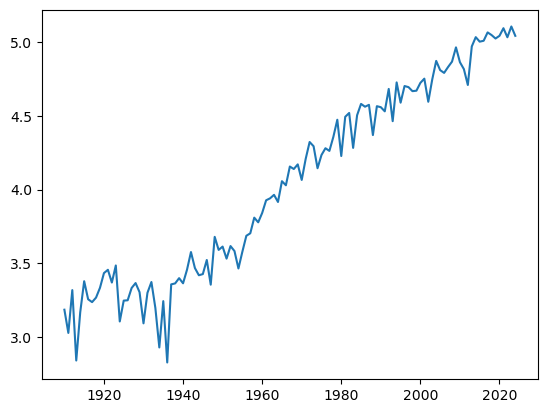

In [46]:
ts_log = pd.Series(np.log(ts_yield))
plt.plot(ts_log)
plt.show()

<Axes: xlabel='year'>

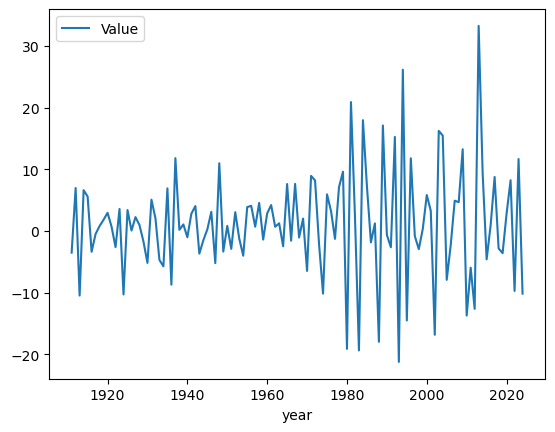

In [47]:
trend = ts.diff() 
trend.plot()


## Weather events

In [48]:
# Ensure datetime format
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])
hist_wx_df['year'] = hist_wx_df['date'].dt.year
hist_wx_df['month'] = hist_wx_df['date'].dt.month

# Filter for growing season (April to October)
growing_season_df = hist_wx_df[hist_wx_df['month'].between(4, 10)]

# Aggregate weather by year
year_weather_summary = growing_season_df.groupby(
    ['year'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [49]:
growing_season_df

,aoi_id,date,tmax,tmin,precip,swvl1,swvl2,adm2_name,adm1_name,rain_flag,year,month
91,USA.14.100_1,2000-04-01,15.714398,6.749730,0.000000,0.308263,0.322690,Will,Illinois,0,2000,4
92,USA.14.100_1,2000-04-02,14.088400,7.540541,0.000000,0.323923,0.319455,Will,Illinois,0,2000,4
93,USA.14.100_1,2000-04-03,14.387382,8.194945,0.000000,0.331260,0.320314,Will,Illinois,0,2000,4
94,USA.14.100_1,2000-04-04,10.822951,1.983510,0.000000,0.319168,0.318296,Will,Illinois,0,2000,4
95,USA.14.100_1,2000-04-05,15.790977,-2.666101,0.029432,0.310549,0.315423,Will,Illinois,1,2000,4
...,...,...,...,...,...,...,...,...,...,...,...,...
8527497,USA.50.9_1,2024-04-26,14.390574,5.418257,0.967823,0.300036,0.309347,Chippewa,Wisconsin,1,2024,4
8527498,USA.50.9_1,2024-04-27,15.066594,8.683216,0.813065,0.370530,0.334744,Chippewa,Wisconsin,1,2024,4
8527499,USA.50.9_1,2024-04-28,13.345714,7.893758,10.281099,0.352298,0.348583,Chippewa,Wisconsin,1,2024,4
8527500,USA.50.9_1,2024-04-29,14.893978,5.650771,7.213643,0.370599,0.371100,Chippewa,Wisconsin,1,2024,4


In [50]:
# Aggregate weather by year
year_state_weather_summary = growing_season_df.groupby(
    ['year', 'adm1_name'], 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [51]:
year_state_weather_summary

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,Illinois,24.604442,15.020123,65535.670913,0.336009,0.335322
1,2000,Indiana,23.362436,13.952075,60648.897403,0.336135,0.337944
2,2000,Iowa,23.715995,13.574263,53146.954852,0.285794,0.277163
3,2000,Kansas,27.664892,16.325456,44858.689580,0.235809,0.234743
4,2000,Kentucky,25.978824,16.301462,30221.324747,0.359820,0.363367
...,...,...,...,...,...,...,...
320,2024,Nebraska,18.049131,5.801481,6969.781912,0.303635,0.297653
321,2024,Ohio,17.879035,8.071720,9104.181406,0.371049,0.376307
322,2024,South Dakota,15.048102,3.705401,6364.375758,0.359257,0.350737
323,2024,Tennessee,21.729669,12.637080,3716.884228,0.400567,0.406302


In [52]:
year_state_weather_summary['adm1_name'] = year_state_weather_summary['adm1_name'].str.upper()

merged_df_2 = year_state_mean.merge(
    year_state_weather_summary,
    how='inner',
    left_on=['year', 'state_name'],
    right_on=['year', 'adm1_name']
)


In [53]:
merged_df_2

,year,state_name,Value,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
0,2000,ILLINOIS,146.156863,ILLINOIS,24.604442,15.020123,65535.670913,0.336009,0.335322
1,2000,INDIANA,146.150562,INDIANA,23.362436,13.952075,60648.897403,0.336135,0.337944
2,2000,IOWA,143.370707,IOWA,23.715995,13.574263,53146.954852,0.285794,0.277163
3,2000,KANSAS,112.553719,KANSAS,27.664892,16.325456,44858.689580,0.235809,0.234743
4,2000,KENTUCKY,125.126263,KENTUCKY,25.978824,16.301462,30221.324747,0.359820,0.363367
...,...,...,...,...,...,...,...,...,...
320,2024,NEBRASKA,184.237705,NEBRASKA,18.049131,5.801481,6969.781912,0.303635,0.297653
321,2024,OHIO,165.831343,OHIO,17.879035,8.071720,9104.181406,0.371049,0.376307
322,2024,SOUTH DAKOTA,154.871429,SOUTH DAKOTA,15.048102,3.705401,6364.375758,0.359257,0.350737
323,2024,TENNESSEE,133.809756,TENNESSEE,21.729669,12.637080,3716.884228,0.400567,0.406302


In [54]:
merged_df_2['soil_moisture_delta'] = merged_df_2['swvl1_mean'] - merged_df_2['swvl2_mean']
merged_df_2['term_stress'] = merged_df_2['tmax_mean'] - merged_df_2['tmin_mean']
merged_df_2['dry_heat_index'] = (merged_df_2['tmax_mean']) / (merged_df_2['precip_sum'] + 1) # adding one to avoid zero div 

In [55]:
# Variabili climatiche da correlare con la resa
features = ['tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'dry_heat_index', 'soil_moisture_delta', 'term_stress']

# Funzione per calcolare le correlazioni per uno stato
def compute_correlations(group):
    correlations = {}
    for feature in features:
        correlations[f"corr_{feature}"] = group['Value'].corr(group[feature])
    return pd.Series(correlations)

# Calcola le correlazioni per ogni stato
correlation_df = merged_df_2.groupby('state_name').apply(compute_correlations).reset_index()

# Visualizza il risultato
print(correlation_df)

      state_name  corr_tmax_mean  corr_tmin_mean  corr_precip_sum  \
0       ILLINOIS       -0.376510       -0.294197        -0.004604   
1        INDIANA       -0.336943       -0.250748        -0.197721   
2           IOWA       -0.307612       -0.274980        -0.084464   
3         KANSAS       -0.474227       -0.254801         0.411380   
4       KENTUCKY       -0.320279       -0.172456         0.135039   
5       MICHIGAN       -0.268213       -0.246181        -0.096203   
6      MINNESOTA       -0.066928       -0.060809         0.098144   
7       MISSOURI       -0.499027       -0.386276         0.110422   
8       NEBRASKA       -0.380835       -0.292271         0.154631   
9           OHIO       -0.199480       -0.065540        -0.069020   
10  SOUTH DAKOTA       -0.467838       -0.379307         0.187002   
11     TENNESSEE       -0.206239       -0.041345         0.355266   
12     WISCONSIN       -0.138485       -0.096677         0.059911   

    corr_swvl1_mean  corr_swvl2_m

/tmp/ipykernel_1635090/1733884016.py:12: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  correlation_df = merged_df_2.groupby('state_name').apply(compute_correlations).reset_index()


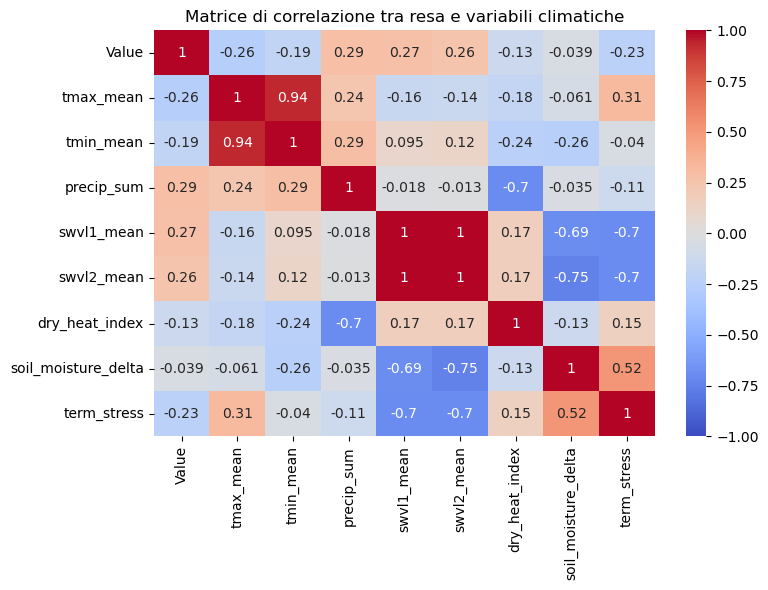

In [56]:
# Calcolo delle correlazioni sull'intero dataset
corr_matrix = merged_df_2[['Value', 'tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'dry_heat_index', 'soil_moisture_delta', 'term_stress']].corr()

# Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice di correlazione tra resa e variabili climatiche")
plt.tight_layout()
plt.show()

In [57]:
year_weather_summary['soil_moisture_delta'] = year_weather_summary['swvl1_mean'] - year_weather_summary['swvl2_mean']
year_weather_summary['term_stress'] = year_weather_summary['tmax_mean'] - year_weather_summary['tmin_mean']
year_weather_summary['dry_heat_index'] = (year_weather_summary['tmax_mean']) / (year_weather_summary['precip_sum'] + 1) # adding one to avoid zero div 

In [58]:
year_weather_summary = year_weather_summary[:-1] # Removing 2024 since the data is not complete

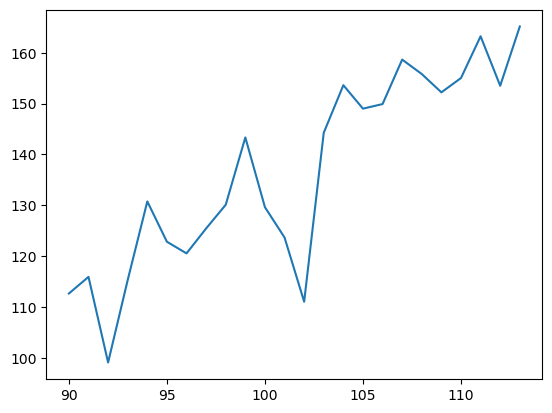

In [59]:
year_mean[(year_mean['year'] >= 2000) & (year_mean['year'] <= 2023)]['Value'].plot()
plt.show()

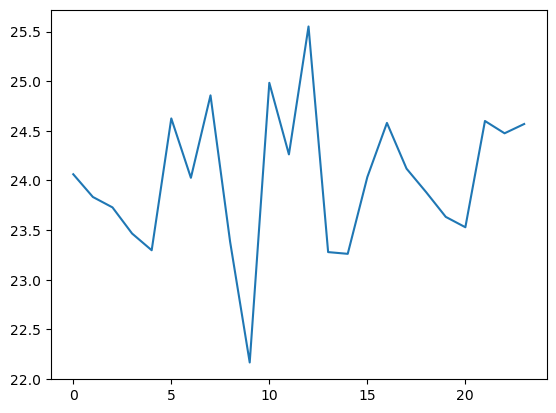

In [60]:
year_weather_summary['tmax_mean'].plot()
plt.show()

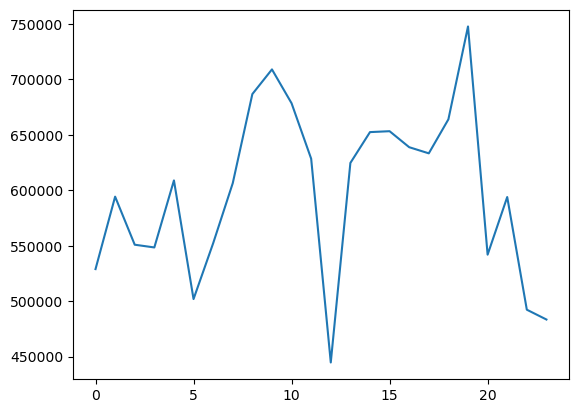

In [61]:
year_weather_summary['precip_sum'].plot()
plt.show()

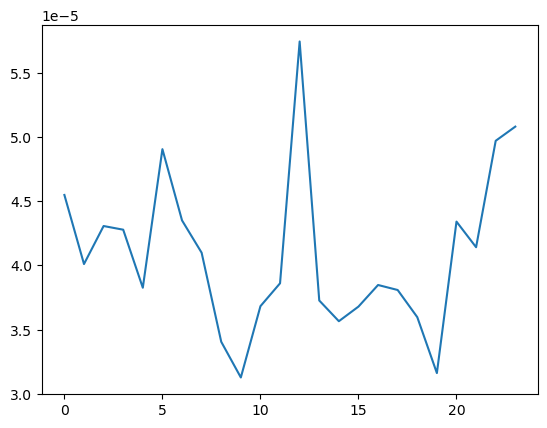

In [62]:
year_weather_summary['dry_heat_index'].plot()
plt.show()

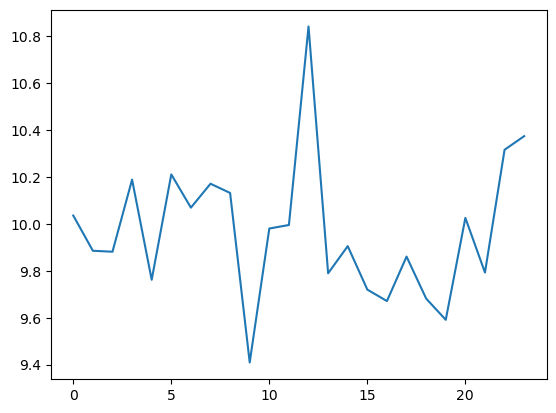

In [63]:
year_weather_summary['term_stress'].plot()
plt.show()

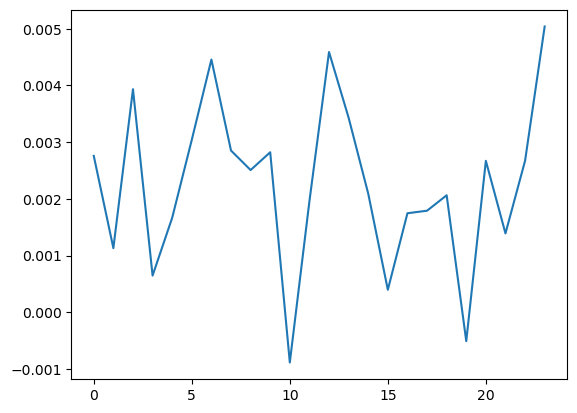

In [64]:
year_weather_summary['soil_moisture_delta'].plot()
plt.show()

By closely analysing the weather data and yield for the period 2000-2023 (range provided for weather data), several things can be noted: <br>
- A sharp decrease in yield around 2012;<br>
- The decrease in yield coincides with a drastic drop in total rainfall; <br>
- Predictably, in addition to the decrease in rainfall, soil moisture also decreased. <br>
- During the same period, it can be observed that the average maximum temperatures were the highest (drought). <br>
- Average maximum temperatures around 25 degrees, combined with good rainfall/soil moisture, allowed for the best yields. <br>

In [65]:
# Aggregate weather by year
weather_summary = growing_season_df.groupby(
    ['year','adm1_name'] 
).agg(
    tmax_mean=('tmax', 'mean'),
    tmin_mean=('tmin', 'mean'),
    precip_sum=('precip', 'sum'),
    swvl1_mean=('swvl1', 'mean'),
    swvl2_mean=('swvl2', 'mean')
    
).reset_index()

In [66]:
weather_summary.sort_values("tmax_mean", ascending=False).head(5)

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
141,2010,Tennessee,28.882612,18.732632,23181.798953,0.319474,0.321904
159,2012,Kansas,28.790511,16.786854,36150.980088,0.208866,0.210051
102,2007,Tennessee,28.620336,18.294796,17649.535423,0.298461,0.295478
146,2011,Kansas,28.459005,16.418536,44025.323462,0.213172,0.213226
289,2022,Kansas,28.409217,16.363027,42373.693255,0.216522,0.215931


In [67]:
weather_summary.sort_values("precip_sum", ascending=False).head(5)

,year,adm1_name,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean
117,2009,Illinois,22.859154,13.993028,92829.773538,0.356875,0.358471
132,2010,Iowa,23.799127,14.181634,92020.647862,0.336306,0.340099
236,2018,Iowa,23.009873,13.255383,85797.373769,0.331853,0.332346
106,2008,Iowa,22.295089,12.362914,85322.648265,0.311979,0.308119
247,2019,Illinois,24.784493,15.486605,83213.326774,0.353195,0.354459


In [68]:
merged_df = year_mean.merge(
    year_weather_summary,
    how='inner',
    left_on=['year'],
    right_on=['year']
)


In [70]:
corr = merged_df[['Value', 'tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean', 'term_stress', 'dry_heat_index', 'soil_moisture_delta' ]].corr()
styled_corr = corr.style.background_gradient(cmap='coolwarm').format(precision=2)
display(styled_corr)


,Value,tmax_mean,tmin_mean,precip_sum,swvl1_mean,swvl2_mean,term_stress,dry_heat_index,soil_moisture_delta
Value,1.00,-0.10,0.04,0.30,0.34,0.34,-0.34,-0.27,-0.17
tmax_mean,-0.10,1.00,0.92,-0.49,-0.65,-0.62,0.63,0.64,0.09
tmin_mean,0.04,0.92,1.00,-0.20,-0.33,-0.30,0.26,0.35,-0.14
precip_sum,0.30,-0.49,-0.20,1.00,0.87,0.87,-0.79,-0.97,-0.64
swvl1_mean,0.34,-0.65,-0.33,0.87,1.00,1.00,-0.91,-0.91,-0.62
swvl2_mean,0.34,-0.62,-0.30,0.87,1.00,1.00,-0.90,-0.91,-0.67
term_stress,-0.34,0.63,0.26,-0.79,-0.91,-0.90,1.00,0.86,0.49
dry_heat_index,-0.27,0.64,0.35,-0.97,-0.91,-0.91,0.86,1.00,0.59
soil_moisture_delta,-0.17,0.09,-0.14,-0.64,-0.62,-0.67,0.49,0.59,1.00


Corn yield shows a positive relationship with water availability (rain and soil moisture) and a negative relationship with high temperatures, especially maximum temperatures.  <br>
This suggests that crops respond well to a temperate and humid climate, while excessive heat can penalise them, a classic effect of heat stress.

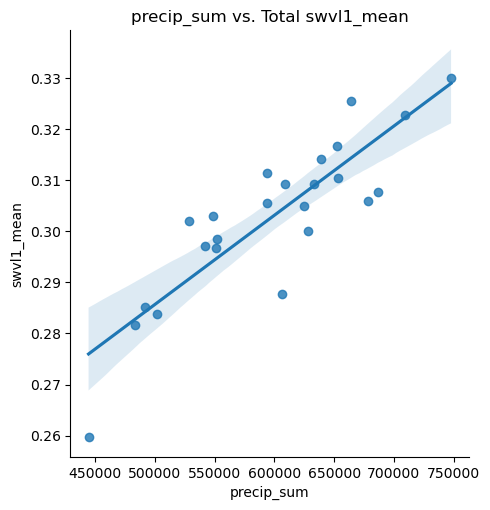

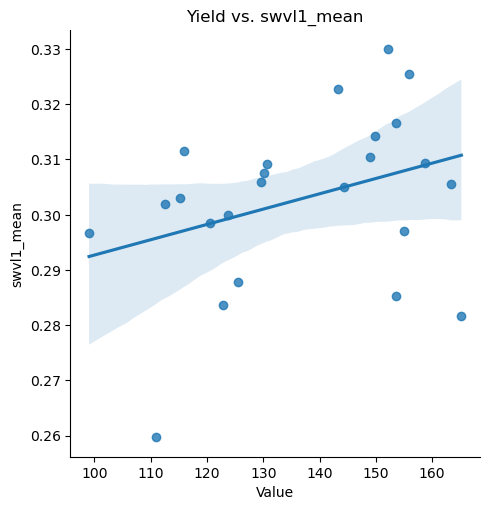

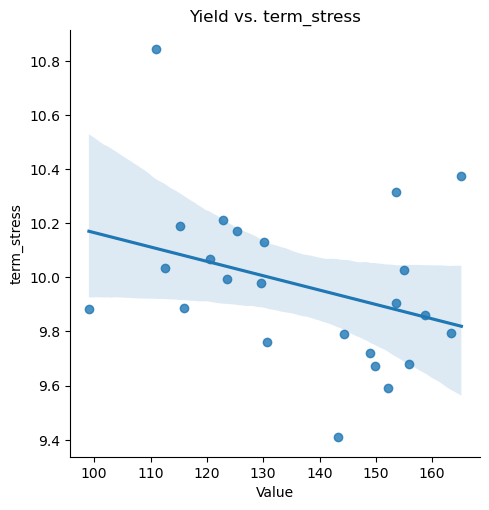

In [71]:
sns.lmplot(data=merged_df, x='precip_sum', y='swvl1_mean')
plt.title('precip_sum vs. Total swvl1_mean')
plt.show()

sns.lmplot(data=merged_df, x='Value', y='swvl1_mean')
plt.title('Yield vs. swvl1_mean')
plt.show()

sns.lmplot(data=merged_df, x='Value', y='term_stress')
plt.title('Yield vs. term_stress')
plt.show()


## Prediction

All the serie

In [141]:
# Creiamo la serie temporale
year_mean.set_index('year', inplace=True)
ts = year_mean[['Value']]

# Verifica
print(ts.head())

          Value
year           
1910  24.149462
1911  20.627957
1912  27.587097
1913  17.106452
1914  23.718280


In [142]:
from statsmodels.tsa.stattools import adfuller

# Test di Dickey-Fuller per la stazionarietà
result = adfuller(ts['Value'])
print(f'p-value: {result[1]}')

# Se p-value < 0.05, la serie è stazionaria
if result[1] < 0.05:
    print("La serie è stazionaria")
else:
    print("La serie non è stazionaria, bisogna differenziare")


p-value: 0.9989453166012883
La serie non è stazionaria, bisogna differenziare


In [143]:
# Differenziamo la serie per renderla stazionaria
ts['Value_diff'] = ts['Value'].diff().dropna()

# Verifica se la serie è ora stazionaria
result = adfuller(ts['Value_diff'].dropna())
print(f'p-value: {result[1]}')

if result[1] < 0.05:
    print("La serie è ora stazionaria")
else:
    print("La serie non è ancora stazionaria")


p-value: 1.7181924023443488e-14
La serie è ora stazionaria


In [144]:
from pmdarima import auto_arima

# Trova automaticamente i parametri ottimali per ARIMA
model = auto_arima(ts['Value'], seasonal=False, stepwise=True, trace=True)
print(model.summary())


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: F

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=783.598, Time=0.23 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=822.051, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=797.885, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=779.358, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=821.996, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=781.165, Time=0.03 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=781.097, Time=0.04 sec


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: F

 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=782.734, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=793.981, Time=0.01 sec

Best model:  ARIMA(0,1,1)(0,0,0)[0] intercept
Total fit time: 0.486 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  115
Model:               SARIMAX(0, 1, 1)   Log Likelihood                -386.679
Date:                Wed, 30 Jul 2025   AIC                            779.358
Time:                        10:59:33   BIC                            787.566
Sample:                             0   HQIC                           782.689
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
int

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/sklearn/utils/deprecation.py:132: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


In [145]:
from statsmodels.tsa.arima.model import ARIMA

# Creiamo il modello ARIMA con i parametri ottimali
best_model = ARIMA(ts['Value'], order=model.order)
best_model_fit = best_model.fit()

# Riassunto del modello
print(best_model_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                  115
Model:                 ARIMA(0, 1, 1)   Log Likelihood                -394.990
Date:                Wed, 30 Jul 2025   AIC                            793.981
Time:                        10:59:37   BIC                            799.453
Sample:                             0   HQIC                           796.201
                                - 115                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.5070      0.067     -7.560      0.000      -0.638      -0.376
sigma2        59.6893      6.716      8.887      0.000      46.525      72.853
Ljung-Box (L1) (Q):                   3.09   Jarque-

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)


In [ ]:
# Previsione per il 2024 
forecast = best_model_fit.forecast(steps=1)

# Risultato della previsione
print(f"Previsione della resa per il 2024: {forecast}")


Previsione della resa per il 2024: 115    157.833175
dtype: float64


/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


From weather data

In [100]:
ts = ts[ts.index > 1999][:-1]

In [107]:
print(ts.index)

Index([2000, 2001, 2002, 2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011,
       2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023],
      dtype='int64', name='year')


In [96]:
# Aggiungi le variabili climatiche come esogene
X = merged_df[['tmax_mean', 'tmin_mean', 'precip_sum', 'swvl1_mean', 'swvl2_mean']]

In [106]:
print(X.index)

RangeIndex(start=0, stop=24, step=1)


In [110]:
X.index = pd.Index(range(2000, 2024), name='year')


In [111]:
from statsmodels.tsa.arima.model import ARIMA

# Creazione del modello ARIMAX (esogene)
model_arimax = ARIMA(ts['Value'], exog=X, order=(1, 0, 0))
model_arimax_fit = model_arimax.fit()

# Riassunto del modello
print(model_arimax_fit.summary())


                               SARIMAX Results                                
Dep. Variable:                  Value   No. Observations:                   24
Model:                 ARIMA(1, 0, 0)   Log Likelihood                 -91.989
Date:                Wed, 30 Jul 2025   AIC                            199.977
Time:                        10:15:53   BIC                            209.402
Sample:                             0   HQIC                           202.477
                                 - 24                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -198.7413    173.742     -1.144      0.253    -539.270     141.787
tmax_mean     -0.0675     12.059     -0.006      0.996     -23.702      23.567
tmin_mean      8.6917     14.853      0.585      0.5

/cluster/raid/home/f89600179/miniforge3/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [116]:
# Dati esogeni per il 2024
X_2024 = pd.DataFrame({
    'tmax_mean': [24.56],
    'tmin_mean': [14.19],
    'precip_sum': [483390],
    'swvl1_mean': [0.28],
    'swvl2_mean': [0.27]
}, index=[2024])

# Previsione
forecast_2024 = model_arimax_fit.forecast(steps=1, exog=X_2024)

# Output
print(f"Previsione della resa per il 2024: {forecast_2024}")

Previsione della resa per il 2024: 2024    171.060644
dtype: float64


## RandomForestRegressor

In [15]:
county_yield = df.groupby(['county_name', 'year'])['Value'].mean().reset_index()

In [16]:
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
weather_year_county_agg = hist_wx_df.groupby(['adm2_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',   # total annual precipitation
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

In [17]:
weather_year_county_agg

,adm2_name,year,tmax,tmin,precip,swvl1,swvl2
0,Adair,2000,17.230468,7.823785,2.129445,0.347013,0.341726
1,Adair,2001,17.254877,8.066719,2.504215,0.367934,0.367083
2,Adair,2002,17.282357,8.190581,2.445558,0.353013,0.351708
3,Adair,2003,16.704757,7.401790,2.558650,0.353137,0.349330
4,Adair,2004,16.966144,7.993609,2.922926,0.369963,0.370884
...,...,...,...,...,...,...,...
15170,Ziebach,2020,16.059635,4.107272,0.926792,0.255164,0.252573
15171,Ziebach,2021,16.772542,5.026129,0.953584,0.241704,0.235043
15172,Ziebach,2022,14.877706,2.885013,0.892846,0.233778,0.221274
15173,Ziebach,2023,14.879375,3.707230,1.247874,0.270203,0.261257


In [19]:
weather_year_county_agg['soil_moisture_delta'] = weather_year_county_agg['swvl1'] - weather_year_county_agg['swvl2']
weather_year_county_agg['term_stress'] = weather_year_county_agg['tmax'] - weather_year_county_agg['tmin']
weather_year_county_agg['dry_heat_index'] = (weather_year_county_agg['tmax']) / (weather_year_county_agg['precip'] + 1) # adding one to avoid zero div 

In [20]:
weather_year_county_agg['adm2_name'] = weather_year_county_agg['adm2_name'].str.upper()  # Ensure consistent casing

In [22]:
df_county = weather_year_county_agg.merge(county_yield, left_on=['adm2_name', 'year'], right_on=['county_name', 'year'], how='inner')


In [23]:
df_county.drop(columns=['adm2_name'], inplace=True)

In [28]:
df_county.columns

Index(['year', 'tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'soil_moisture_delta', 'term_stress', 'dry_heat_index', 'county_name',
       'Value'],
      dtype='object')

In [ ]:
# Ensure 'date' is a datetime object
hist_wx_df['date'] = pd.to_datetime(hist_wx_df['date'])

# Extract year from date
hist_wx_df['year'] = hist_wx_df['date'].dt.year

# Group by AOI and year, then aggregate
yearly_agg_2 = hist_wx_df.groupby(['aoi_id', 'adm2_name', 'adm1_name', 'year']).agg({
    'tmax': 'mean',
    'tmin': 'mean',
    'precip': 'mean',   
    'swvl1': 'mean',
    'swvl2': 'mean'
}).reset_index()

year_2024 = yearly_agg_2[yearly_agg_2['year'] == 2024]
year_2024
year_2024.drop(columns=['aoi_id', 'adm1_name'], inplace=True)
year_2024.rename(columns={'adm2_name': 'county_name'}, inplace=True)

C:\Users\Tony\AppData\Local\Temp\ipykernel_14972\2463452130.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024.drop(columns=['aoi_id', 'adm1_name'], inplace=True)
C:\Users\Tony\AppData\Local\Temp\ipykernel_14972\2463452130.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024.rename(columns={'adm2_name': 'county_name'}, inplace=True)


In [31]:
year_2024['soil_moisture_delta'] = year_2024['swvl1'] - year_2024['swvl2']
year_2024['term_stress'] = year_2024['tmax'] - year_2024['tmin']
year_2024['dry_heat_index'] = (year_2024['tmax']) / (year_2024['precip'] + 1) # adding one to avoid zero div 

C:\Users\Tony\AppData\Local\Temp\ipykernel_14972\1971668459.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024['soil_moisture_delta'] = year_2024['swvl1'] - year_2024['swvl2']
C:\Users\Tony\AppData\Local\Temp\ipykernel_14972\1971668459.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  year_2024['term_stress'] = year_2024['tmax'] - year_2024['tmin']
C:\Users\Tony\AppData\Local\Temp\ipykernel_14972\1971668459.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

In [ ]:
df_county = df_county[df_county['year'] != 2024]  # Exclude year 2024 from the main dataset

In [38]:
# Importing necessary libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.impute import SimpleImputer


# Load your data
data = df_county

# Data Preprocessing
# Handle missing values and categorical columns
X = data.drop(columns=['Value'])
y = data['Value']

# List categorical columns to be one-hot encoded or label encoded
categorical_columns = ['county_name', 'year']  # Adjust based on actual categorical columns

# List continuous columns to be scaled
numerical_columns = ['tmax', 'tmin', 'precip', 'swvl1', 'swvl2',
       'soil_moisture_delta', 'term_stress', 'dry_heat_index']

# Create the preprocessing pipeline
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),  # Impute missing values
    ('scaler', StandardScaler())  # Scale numerical features
])

categorical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),  # Impute missing categorical data
    ('encoder', OneHotEncoder(handle_unknown='ignore'))  # One-hot encode categorical columns
])

# Combine pipelines into a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_columns),
        ('cat', categorical_pipeline, categorical_columns)
    ]
)

# Model pipeline with a Random Forest Regressor
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))  
])

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the model
model_pipeline.fit(X_train, y_train)

# Predictions
y_pred = model_pipeline.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')



Mean Absolute Error: 15.301777872605326
Mean Squared Error: 414.2023148014033
R-squared: 0.652459695059276


In [39]:
from sklearn.ensemble import RandomForestRegressor
import numpy as np

# Fit Random Forest
rf = Pipeline([
    ('preprocessor', preprocessor),
    ('model', RandomForestRegressor(n_estimators=100, random_state=42))
])
rf.fit(X_train, y_train)

# Get prediction from each tree
model = rf.named_steps['model']
X_2024_transformed = rf.named_steps['preprocessor'].transform(year_2024)

tree_preds = np.array([tree.predict(X_2024_transformed) for tree in model.estimators_])
mean_pred = tree_preds.mean()
std_pred = tree_preds.std()

print(f"2024 Prediction (Random Forest): {mean_pred:.2f} ± {std_pred:.2f} bu/acre")


2024 Prediction (Random Forest): 131.09 ± 33.24 bu/acre


 Linear Regression
Linear Regression is a simple, interpretable model that assumes a linear relationship between the input features and the target variable.

In [40]:
from sklearn.linear_model import LinearRegression

# Using Linear Regression instead of Random Forest
linear_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', LinearRegression())  # Linear Regression Model
])

# Train the model
linear_model_pipeline.fit(X_train, y_train)

# Predictions
y_pred_linear = linear_model_pipeline.predict(X_test)

# Evaluate the model
mae_linear = mean_absolute_error(y_test, y_pred_linear)
mse_linear = mean_squared_error(y_test, y_pred_linear)
r2_linear = r2_score(y_test, y_pred_linear)

print(f'Linear Regression - Mean Absolute Error: {mae_linear}')
print(f'Linear Regression - Mean Squared Error: {mse_linear}')
print(f'Linear Regression - R-squared: {r2_linear}')


Linear Regression - Mean Absolute Error: 13.865980863927044
Linear Regression - Mean Squared Error: 342.8925324671803
Linear Regression - R-squared: 0.7122928312153962


In [41]:
import statsmodels.api as sm

# Preprocess training data
X_design = preprocessor.fit_transform(X_train)

# Convert to dense array if it's sparse
if hasattr(X_design, "toarray"):
    X_design = X_design.toarray()

# Add intercept
X_design = sm.add_constant(X_design)

# Fit statsmodels OLS
ols_model = sm.OLS(y_train, X_design).fit()

# Preprocess 2024 input
X_2024 = preprocessor.transform(year_2024)

# Convert to dense if sparse
if hasattr(X_2024, "toarray"):
    X_2024 = X_2024.toarray()

# Add intercept
X_2024 = sm.add_constant(X_2024)

# Prediction with confidence interval
pred_2024 = ols_model.get_prediction(X_2024)
summary_frame = pred_2024.summary_frame(alpha=0.05)

point = summary_frame["mean"].values[0]
ci_lower = summary_frame["obs_ci_lower"].values[0]
ci_upper = summary_frame["obs_ci_upper"].values[0]

print(f"2024 Prediction (OLS): {point:.2f} bu/acre, 95% CI: [{ci_lower:.2f}, {ci_upper:.2f}]")



2024 Prediction (OLS): 120.72 bu/acre, 95% CI: [85.77, 155.67]


XGBoost
XGBoost (Extreme Gradient Boosting) is a highly optimized implementation of gradient boosting that often yields high performance and efficiency.

In [43]:
import xgboost as xgb

# Using XGBoost Regressor
xgb_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', xgb.XGBRegressor(n_estimators=100, random_state=42))  # XGBoost Regressor
])

# Train the model
xgb_model_pipeline.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model_pipeline.predict(X_test)

# Evaluate the model
mae_xgb = mean_absolute_error(y_test, y_pred_xgb)
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
r2_xgb = r2_score(y_test, y_pred_xgb)

print(f'XGBoost - Mean Absolute Error: {mae_xgb}')
print(f'XGBoost - Mean Squared Error: {mse_xgb}')
print(f'XGBoost - R-squared: {r2_xgb}')


XGBoost - Mean Absolute Error: 14.84023702441402
XGBoost - Mean Squared Error: 380.162368028635
XGBoost - R-squared: 0.6810212290218425


 Support Vector Regression (SVR)
Support Vector Regression (SVR) is a version of Support Vector Machines (SVM) for regression tasks. It works by finding a hyperplane that best fits the data in a high-dimensional space.

In [44]:
from sklearn.svm import SVR

# Pipeline con Support Vector Regression
svr_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', SVR(kernel='rbf', C=100, epsilon=0.1))  # puoi modificare i parametri
])

# Training
svr_pipeline.fit(X_train, y_train)

# Predizioni
y_pred_svr = svr_pipeline.predict(X_test)

# Valutazione
print("=== Support Vector Regression ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_svr)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_svr)}")
print(f"R²: {r2_score(y_test, y_pred_svr)}")


=== Support Vector Regression ===
MAE: 11.913558870887591
MSE: 267.9775528589624
R²: 0.7751509416780371


In [45]:
import numpy as np
from sklearn.utils import resample
n_bootstraps = 10
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model (use e.g. SVR or ElasticNet)
    model = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', SVR())  # or ElasticNet()
    ])
    model.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")


2024 Yield Prediction: 141.87 ± 1.56 bu/acre


ElasticNet (Regularized Linear Model)
ElasticNet combines L1 (Lasso) and L2 (Ridge) regularization, which can help improve the model's generalization when there is multicollinearity in the data.

In [46]:
from sklearn.linear_model import ElasticNet

# Pipeline con ElasticNet
elastic_net_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', ElasticNet(alpha=0.001, l1_ratio=0.5, random_state=42))  
])

# Training
elastic_net_pipeline.fit(X_train, y_train)

# Predizioni
y_pred_en = elastic_net_pipeline.predict(X_test)

# Valutazione
print("=== ElasticNet Regression ===")
print(f"MAE: {mean_absolute_error(y_test, y_pred_en)}")
print(f"MSE: {mean_squared_error(y_test, y_pred_en)}")
print(f"R²: {r2_score(y_test, y_pred_en)}")


=== ElasticNet Regression ===
MAE: 14.590800884843901
MSE: 374.839625546663
R²: 0.6854873256108788


c:\ProgramData\anaconda3\envs\env_master\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:639: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 51842.71130361268, tolerance: 1227.7979681629536
  model = cd_fast.sparse_enet_coordinate_descent(


In [47]:
import numpy as np
from sklearn.utils import resample
n_bootstraps = 50
predictions = []

for i in range(n_bootstraps):
    # Bootstrap sample
    X_resampled, y_resampled = resample(X_train, y_train, replace=True, random_state=i)

    # Fit model 
    model_en = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', ElasticNet())  # or ElasticNet()
    ])
    model_en.fit(X_resampled, y_resampled)

    # Predict 2024
    pred = model_en.predict(year_2024)[0]  # Assuming 1-row input
    predictions.append(pred)

predictions = np.array(predictions)
mean_prediction = predictions.mean()
std_prediction = predictions.std()

print(f"2024 Yield Prediction: {mean_prediction:.2f} ± {std_prediction:.2f} bu/acre")

2024 Yield Prediction: 157.93 ± 0.86 bu/acre
